# Water Quality Parameters - istSOS upload

The current notebook introduces the computation and ingestion of the aggregate descriptive statistics, on a basins level, of the Water Quality Paramenters produced under the framework of SIMILE project into the [istSOS](http://www.istsos.org/) platform. Additional information on the istSOS capabilities and REST API can be found in its [documentation](http://istsos.org/en/latest/doc/) page.

## 0. Setup Working Environment

### Working libraries and Notebook setup

In [6]:
# Styling notebook

# System
import os
import sys

# Import scripts libraries for the project
sys.path.append('./src/python')


# Import the function to update the notebook style
from nbConfig import (css_styling)

css_styling()

In [7]:
# Data
import numpy as np
import pandas as pd
import pytz
import json
import requests

# Spatial Data
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show_hist

# Import custom libraries
import wqp_istSOS as istsos
import wqpFunctions as wqp

# Widgets
import ipywidgets as wg

In [8]:
# Current Working Directories
cwd = {
    'local': '.',
    'in': './in/data/',
    'out': './out/istSOS/',
    'vector': './vector',
}

### istSOS client authentication

In [4]:
c = istsos.istSOSClient(TOKEN_URL=istsos.istSOSClient.TOKEN_URL,
                        HEADERS=istsos.istSOSClient.HEADERS,
                        API_ENDPOINT=istsos.istSOSClient.API_ENDPOINT,
                        ENV_FILE='../env.json')

In [5]:
#
assigned_sensor_id = c.getProcedureIDs(istsos.istSOSClient.PROCEDURES_LIST)

Creating authentication token.

The procedure SATELLITE_CHL_TURB_LU_EAST has not been provided with an ID.
The procedure SATELLITE_CHL_TURB_LU_WEST has not been provided with an ID.
The procedure SATELLITE_CHL_TURB_MA_ALL has not been provided with an ID.
The procedure SATELLITE_WT_LU_EAST has not been provided with an ID.
The procedure SATELLITE_WT_LU_WEST has not been provided with an ID.
The procedure SATELLITE_WT_MA_ALL has not been provided with an ID.
The procedure SATELLITE_CHL_TURB_LU_EAST has not been provided with an ID.
The procedure SATELLITE_CHL_TURB_LU_WEST has not been provided with an ID.
The procedure SATELLITE_CHL_TURB_MA_ALL has not been provided with an ID.
The procedure SATELLITE_WT_LU_EAST has not been provided with an ID.
The procedure SATELLITE_WT_LU_WEST has not been provided with an ID.
The procedure SATELLITE_WT_MA_ALL has not been provided with an ID.


## 1. Vector Data - Basins

In this section, we import the vector layer for the computation of the aggregate statistics, based in the features of the imported layer. In this case, for the division of the lakes ata a basing level.

In [6]:
# Layer dataset
gdf_basins = gpd.read_file(os.path.join(cwd['vector'],'simile_basins','simile_basins.shp'))

In [7]:
gdf_basins

,id,Nome,Lago,geometry
0,1,CO_NORTH,Como,"POLYGON ((520421.398 5093134.438, 518210.057 5..."
1,2,CO_EAST,Como,"POLYGON ((529880.155 5077362.548, 529751.125 5..."
2,3,CO_WEST,Como,"POLYGON ((518210.057 5094904.495, 520421.398 5..."
3,4,LU_EAST,Lugano,"MULTIPOLYGON (((497195.068 5088902.843, 496990..."
4,5,LU_WEST,Lugano,"POLYGON ((492500.964 5083295.972, 492437.780 5..."
5,6,MA_ALL,Maggiore,"POLYGON ((467817.948 5063396.238, 467709.246 5..."


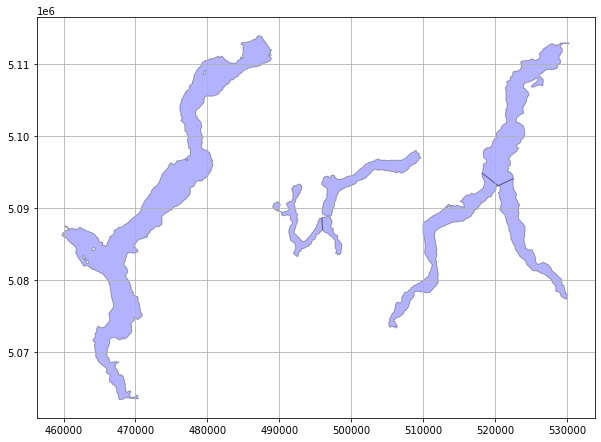

In [8]:
fig ,ax = plt.subplots(1,1,figsize=(10,10))
gdf_basins.plot(ax = ax, color="blue", edgecolor="black", alpha = 0.3)
ax.grid()

## 2. Compute Descriptive Statistics - Basin Level

### Procedure Selection - Data Formatting for upload

In [9]:
procedure = wg.Select(
    options = istsos.istSOSClient.PROCEDURES_LIST,
    value = istsos.istSOSClient.PROCEDURES_LIST[0],
    description = 'Select the procedure:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='50%', height='100px'),
)

In [10]:
sensor = wg.Select(
    options = ['S3', 'L8'],
    value = 'S3',
    description = 'Select the sensor:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='50%', height='100px'),
)

In [11]:
wg.HBox([procedure, sensor])

In [12]:
# c.updateBearerToken()
data = c.getRequestSample(procedure.value)

GetObservation requested successfully executed


In [13]:
data

{'name': 'SATELLITE_CHL_TURB_CO_EAST',
 'samplingTime': {'beginPosition': '2020-01-01T00:01:00+00:00',
  'endPosition': '2020-01-17T00:01:00+00:00',
  'duration': 'P16D'},
 'procedure': 'urn:ogc:def:procedure:x-istsos:1.0:SATELLITE_CHL_TURB_CO_EAST',
 'observedProperty': {'CompositePhenomenon': {'id': 'comp_28',
   'dimension': '5',
   'name': 'timeSeriesOfObservations'},
  'component': ['urn:ogc:def:parameter:x-istsos:1.0:time:iso8601',
   'urn:ogc:def:parameter:x-istsos:1.0:water:Chl',
   'urn:ogc:def:parameter:x-istsos:1.0:water:Chl:qualityIndex',
   'urn:ogc:def:parameter:x-istsos:1.0:water:Turb',
   'urn:ogc:def:parameter:x-istsos:1.0:water:Turb:qualityIndex']},
 'featureOfInterest': {'name': 'urn:ogc:def:feature:x-istsos:1.0:Point:COMO_EAST',
  'geom': "<gml:Point srsName='EPSG:4326'><gml:coordinates>9.29834126943655,45.9322514262755,197.3</gml:coordinates></gml:Point>"},
 'result': {'DataArray': {'elementCount': '5',
   'field': [{'name': 'Time',
     'definition': 'urn:ogc:def:

### Export Basin Stats to CSV files

If needed to remove double-check that the nan values in the datasets are identified correctly uncomment the following cell. As a first step, the images will be subset to same size images.

In [4]:
# Produce the cropped maps for the WQP of interest
products_list = [
    'wqp',
    'wqp_cloud_mask',
    'wqp_no_clip',
    'wqp_no_mask',
]
# Typology of the products
typology_list = [
    'chl',
    'tsm',
    'lswt'
]
# Subset to the buffer size (same used as for the coregistration)
featureGeometry = os.path.join(cwd['vector'],'simile_laghi_extent/simile_laghi_extent_600m_buff.shp')

In [5]:
products = wg.Select(
    options = products_list,
    value = products_list[0],
    description = 'Select the products:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='50%', height='100px'),
)

typology = wg.Select(
    options = typology_list,
    value = typology_list[0],
    description = 'Select the WQP type:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='50%', height='100px'),
)

# Widgets
wg.HBox([products, typology])

In [69]:
in_path = os.path.join(cwd['in'],'wqp',sensor.value,products.value,typology.value)
out_path = os.path.join(in_path,'cropped')
print

# shared_maps = list(set(os.listdir(in_path)).intersection(os.listdir(out_path)))
missing_maps = list(set(os.listdir(in_path)) ^ set(os.listdir(out_path)))
print(missing_maps)
for root, dirs, files in os.walk(in_path):
    for f in missing_maps:
        if ((f.endswith('.tif')) & (dirs==['cropped'])):
            chl_map = os.path.join(in_path,f)
            print(chl_map)
            wqp_map = wqp.wqp(chl_map)
            wqp_map.readWQP()
            wqp_map.cropRasterByFeatures(featureGeometry,'Nome')
            d_temp = wqp_map.crops['wqp']['crop']
            d_temp[d_temp<0] = 0
            wqp_map.crops['wqp']['crop'] = d_temp
            wqp_map.saveMaskedImage(os.path.join(out_path,wqp_map.name+'.tif'),'wqp',band=1)
            wqp_map.image.close()

./in/data/wqp\S3\wqp_no_mask\tsm\cropped
['cropped']


In [70]:
# Take into account that some of the files have already been analyzed
stats = os.path.join(out_path,f'lakesStats_{sensor.value}_{products.value}_{typology.value}.csv')
data = []
for root, dirs, files in os.walk(out_path):
    if os.path.exists(stats):
        df = pd.read_csv(stats)
        stats_file_names = set(list(df['name']+'.tif'))
        missing_stats = list(stats_file_names ^ s+et(os.listdir(out_path)))
    else:
        missing_stats = files
    for file in missing_stats:
        if (file.endswith('.tif')):
            print(file)
            f = os.path.join(root,file)
            # Read file
            src = wqp.wqp(f)
            src.readWQP()
            src.name

            # Compute statistics for the basins polygons
            src.computeStatistics(gdf_basins, 'Nome',"count min mean max median std  percentile_25 percentile_50 percentile_75", 0)

            # Format output
            data.append(wqp.wqp.exportWQPFormatEstimates(src))

df = pd.concat(data)
# Add values to csv file
istsos.appendStatsFile(df, stats)

S3A_TSM_IT_20190215T100832_L1.tif
S3A_TSM_IT_20190315T094218_L1.tif
S3A_TSM_IT_20190322T100102_L1.tif
S3A_TSM_IT_20201124T100835_L1.tif
S3A_TSM_IT_20210110T094956_L1.tif
S3A_TSM_IT_20210417T093504_L1.tif
S3A_TSM_IT_20210606T093850_L1.tif
S3A_TSM_IT_20210625T094620_L1.tif
S3A_TSM_IT_20210817T101226_L1.tif
S3A_TSM_IT_20210818T094615_L1.tif
S3A_TSM_IT_20210917T100842_L1.tif
S3A_TSM_IT_20210922T093847_L1.tif
S3A_TSM_IT_20211014T100844_L1.tif
S3A_TSM_IT_20211211T100457_L1.tif
S3A_TSM_IT_20220201T091625_L1.tif
S3A_TSM_IT_20220203T100503_L1.tif
S3A_TSM_IT_20220602T102000_L1.tif
S3A_TSM_IT_20220603T095349_L1.tif
S3A_TSM_IT_20220604T092738_L1.tif
S3A_TSM_IT_20220607T095004_L1.tif
S3A_TSM_IT_20220608T092353_L1.tif
S3A_TSM_IT_20220610T101230_L1.tif
S3A_TSM_IT_20220611T094619_L1.tif
S3A_TSM_IT_20220612T092008_L1.tif
S3A_TSM_IT_20220614T100845_L1.tif
S3A_TSM_IT_20220615T094234_L1.tif
S3A_TSM_IT_20220616T091624_L1.tif
S3A_TSM_IT_20220618T100501_L1.tif
S3A_TSM_IT_20220619T093850_L1.tif
S3A_TSM_IT_202

In [72]:
df.head()

,name,path,sensor,typology,crs,date,min_CO_NORTH,max_CO_NORTH,mean_CO_NORTH,count_CO_NORTH,...,percentile_75_LU_WEST,min_MA_ALL,max_MA_ALL,mean_MA_ALL,count_MA_ALL,std_MA_ALL,median_MA_ALL,percentile_25_MA_ALL,percentile_50_MA_ALL,percentile_75_MA_ALL
0,S3A_TSM_IT_20190215T100832_L1,./in/data/wqp\S3\wqp_no_mask\tsm\cropped\S3A_T...,S3A,TSM,IT,2019-02-15 10:08:32,0.00585989,226.065,4.85409,686,...,0.974544,0.00569881,228.702,4.43418,2191,24.3502,0.742448,0.545363,0.742448,0.849582
0,S3A_TSM_IT_20190315T094218_L1,./in/data/wqp\S3\wqp_no_mask\tsm\cropped\S3A_T...,S3A,TSM,IT,2019-03-15 09:42:18,0.00586798,273.469,11.5916,687,...,1.08982,0.00575296,251.203,6.78415,2220,35.1079,0.322699,0.0198906,0.322699,0.872301
0,S3A_TSM_IT_20190322T100102_L1,./in/data/wqp\S3\wqp_no_mask\tsm\cropped\S3A_T...,S3A,TSM,IT,2019-03-22 10:01:02,0.00627061,228.181,7.16166,667,...,1.67015,0.00581443,233.851,6.31492,2171,29.9268,1.28983,1.08387,1.28983,1.72302
0,S3A_TSM_IT_20201124T100835_L1,./in/data/wqp\S3\wqp_no_mask\tsm\cropped\S3A_T...,S3A,TSM,IT,2020-11-24 10:08:35,0.0323497,222.628,4.9145,690,...,4.96141,0.0285659,216.347,3.36864,2184,15.4075,1.86413,1.35684,1.86413,2.38898
0,S3A_TSM_IT_20210110T094956_L1,./in/data/wqp\S3\wqp_no_mask\tsm\cropped\S3A_T...,S3A,TSM,IT,2021-01-10 09:49:56,0.00513515,243.12,7.20272,671,...,0.222264,0.00528183,236.99,5.80118,2161,31.9355,0.108023,0.0288815,0.108023,0.244338


### istSOS JSON format

In case of S3, it is needed to import both reference data files for the computed statistics

In [ ]:
# Load the statistics files
file_name = f'lakesStats_{sensor.value}.csv'
df = pd.read_csv(os.path.join(cwd['out'],sensor.value,file_name),delimiter=";")
df.date = pd.to_datetime(df.date)

In [ ]:
df = df.dropna()
df = df.sort_values(by=['date'])
df = df.round(2)
df.shape

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.head()

In [ ]:
c.__dict__

In [ ]:
a = istsos.updateDataRequest(df=df,
                    dataSample=data, 
                    WQP_DEFINITIONS=istsos.istSOSClient.WQP_DEFINITIONS,
                    WQP_PROCEDURES=istsos.istSOSClient.WQP_PROCEDURES,
                    PROCEDURE=procedure.value)

In [ ]:
a

In [ ]:
# # Get Observation
# SERVICE_NAME = 'demo'
# OFFERING_NAME = 'temporary'
# PROCEDURE_NAME = 'SATELLITE_CHL_TURB_CO_EAST'
# DEFINITION_URNs = 'urn:ogc:def:parameter:x-istsos:1.0:water:Chl'
# BEGIN_TIME = "2020-01-01T00:01:00+01"
# END_TIME = "2020-01-17T00:01:00+01"

# url_base = "https://istsos.ddns.net/istsos/"
# url_test =f"{url_base}/wa/istsos/services/{SERVICE_NAME}/operations/getobservation/offerings/{OFFERING_NAME}/procedures/{PROCEDURE_NAME}/observedproperties/{DEFINITION_URNs}/eventtime/{BEGIN_TIME}/{END_TIME}"
# resp = requests.get(url_test, headers=c.requestHeaders)
# resp.text


In [ ]:
# WQP_PROCEDURES = ['CHL','TURB','WT']
# a = procedure.value.split('_')
# wqps = list(set(a).intersection(WQP_PROCEDURES))


In [ ]:

# # INSERT OBSERVATION PARAMETERS

# ########## PARAMETERS TO BE EDITED ####################
# LAKE = 'CO' # {CO: COMO, LU: LUGANO, MA: MAGGIORE}
# WQP_INPUT = ['LSWT'] #['LSWT','CHL','TSM']
# #######################################################

# DATE_START = pytz.utc.localize(df.date.min()).isoformat().replace('+00:00','Z')
# DATE_END = pytz.utc.localize(df.date.max()).isoformat().replace('+00:00','Z')


# if LAKE == 'CO':
#     BASINS_LIST = ['CO_NORTH','CO_EAST','CO_WEST']
# elif LAKE == 'LU':
#     BASINS_LIST = ['LU_EAST','LU_WEST']
# elif LAKE == 'MA':
#     BASINS_LIST = ['MA_ALL']
    
# # Observed properties
# OP_COMPOSITE_PHENOMENON_ID = 'comp_1' #random name?
# OP_COMPOSITE_PHENOMENON_DIMENSION = '{}'.format(len(WQP_INPUT)+1) #int number of input observed variables (not observations)
# OP_COMPONENT = ["urn:ogc:def:parameter:x-istsos:1.0:time:iso8601"]
# for wqp in WQP_INPUT: #Observed parameters names: {'lswt':'water-temperature';'chl'}
#     if 'LSWT' in wqp:
#         OP_COMPONENT.append("urn:ogc:def:parameter:x-istsos:1.0:water-temperature")
#     elif 'CHL' in wqp:
#         OP_COMPONENT.append("urn:ogc:def:parameter:x-istsos:1.0:water:Chl")
#     elif 'TSM' in wqp:
#         OP_COMPONENT.append("urn:ogc:def:parameter:x-istsos:1.0:water:Turb")

# #Results
# RES_DA_ELEMENT_COUNT = OP_COMPOSITE_PHENOMENON_DIMENSION # Does this parameter have the same magnitude as the composite dimension?
# RES_DA_FIELDS = [
#     {
#         "name": "Time",
#         "definition": "urn:ogc:def:parameter:x-istsos:1.0:time:iso8601"
#     },
# ]
# for wqp in WQP_INPUT: #Observed parameters names: {'lswt':'water-temperature';'chl'}
#     if 'LSWT' == wqp:
#         RES_DA_FIELDS.append(
#             {
#                 "name": "water-temperature",
#                 "definition":"urn:ogc:def:parameter:x-istsos:1.0:water-temperature",
#                 "uom":"\u00b0C"
#             }
#         )
#     elif 'CHL' == wqp:
#         RES_DA_FIELDS.append(
#             {
#                 "name": "water-Chl",
#                 "definition":"urn:ogc:def:parameter:x-istsos:1.0:water:Chl",
#                 "uom":"mg/m^3"
#             }
#         )
#     elif 'TSM' == wqp:
#         RES_DA_FIELDS.append(
#             {
#                 "name": "water-Turb",
#                 "definition":"urn:ogc:def:parameter:x-istsos:1.0:water:Turb",
#                 "uom":"g/m^3"
#             }
#         )

# # Create insertObsevartion model for istSOS depending on the procedure.
# for PROCEDURE in PROCEDURES_LIST:
#     obs = {
#         "AssignedSensorId":f"{ASSIGNED_SENSOR_ID[PROCEDURE]}",
#         "ForceInsert":"false",
#         "Observation":{
#             "name":f"{PROCEDURE}",
#             "samplingTime":{
#             "beginPosition":f"{DATE_START}",
#             "endPosition":f"{DATE_END}"
#             },
#             "procedure":f"urn:ogc:def:procedure:x-istsos:1.0:{PROCEDURE}",
#             "observedProperty": {
#                 "CompositePhenomenon":{
#                     "id":f"{OP_COMPOSITE_PHENOMENON_ID}", 
#                     "dimension":f"{OP_COMPOSITE_PHENOMENON_DIMENSION}", 
#                     "name":"timeSeriesOfObservations"
#                 },
#                 "component": OP_COMPONENT
#             },
#             "featureOfInterest":{ # Is it necessary to assign the value to a geometry? 
#                 "name":f"urn:ogc:def:feature:x-istsos:1.0:Point:{PROCEDURE}",
#                 "geom":f"{istsos.getGMLfeature(os.path.join(cwd['out'],'procedures_istSOS'), PROCEDURE+"_point")}" 
#             },
#             "result": {
#                 "DataArray": {
#                     "elementCount":f"{RES_DA_ELEMENT_COUNT}",
#                     "field": RES_DA_FIELDS,
#                     "values": istsos.resultsWQPvalues(df,'_'.join(PROCEDURE.split('_')[-2:])),#BASIN
#                 }
#             }
#         }
#     }
#     print('_'.join(PROCEDURE.split('_')[-2:]))
#     with open(os.path.join(cwd['out'],f"{PROCEDURE}.json"), "w", encoding="UTF-8") as outfile:
#         json.dump(obs, outfile, ensure_ascii=False, indent=4)

### Data Ingestion to istSOS

In [ ]:
obs = {
    "AssignedSensorId":f"{assigned_sensor_id[procedure.value]}",
    "ForceInsert":"true",
    "Observation": a
}

In [ ]:
print(os.path.join(cwd['out'],f"{procedure.value}.json"))

In [ ]:
with open(os.path.join(cwd['out'],f"{procedure.value}.json"), "w", encoding="UTF-8") as outfile:
    json.dump(obs, outfile, ensure_ascii=False, indent=4)

In [ ]:
c.updateBearerToken()
c.requestHeaders

In [ ]:
file_name_json = 'SATELLITE_CHL_TURB_CO_WEST.json'
filepath = os.path.join(cwd['out'], sensor.value,file_name_json)
f = open(filepath)

data = json.load(f)
d=json.dumps(obs)

#Insert Observation into istSOS test
url = 'https://istsos.ddns.net/istsos/wa/istsos/services/demo/operations/insertobservation'
response = requests.post(url,data=d,headers=c.requestHeaders)
print(response.status_code)
print(response.text)

In [ ]:
data

In [ ]:
url_base = "https://istsos.ddns.net/istsos/wa/istsos/services/demo"
# # Sample request. Retrieve al the available procedures in the platform
# url_test = f"{url_base}/procedures/operations/getlist"
url_test =f"{url_base}/procedures/SATELLITE_WT_CO_NORTH"
# url_test =f"{url_base}/procedures/SATELLITE_CHL_TURB_CO_NORTH"
resp = requests.get(url_test, data=payload, headers=headers_req)
resp.text

In [ ]:
data

In [ ]:
file_name_json = 'SATELLITE_CHL_TURB_CO_NORTH_2.json'
filepath = os.path.join(cwd['out'], sensor.value,file_name_json)
f = open(filepath)
data = json.load(f)
d=json.dumps(data)
d

### Testing istSOS API  calls

In [ ]:
url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/demo/procedures/operations/getlist"
resp = requests.get(url_test, data=payload, headers=headers_req)
resp.text

In [ ]:
url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/demo/procedures/operations/geojson"
resp = requests.get(url_test, data=payload, headers=headers_req)
resp.text

In [ ]:
# Get Offerings
url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/demo/offerings/operations/getlist"
resp = requests.get(url_test, data=payload, headers=headers_req)
resp.text

In [ ]:
# Get Observation
SERVICE_NAME = 'demo'
OFFERING_NAME = 'temporary'
PROCEDURE_NAME = 'SATELLITE_CHL_TURB_CO_WEST'
DEFINITION_URNs = 'urn:ogc:def:parameter:x-istsos:1.0:water:Chl&urn:ogc:def:parameter:x-istsos:1.0:water:Turb'
BEGIN_TIME = "2019-01-04T09:54:16Z"
END_TIME = "2022-05-26T09:58:18Z"

url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/{SERVICE_NAME}/operations/getobservation/offerings/{OFFERING_NAME}/procedures/{PROCEDURE_NAME}/observedproperties/{DEFINITION_URNs}/eventtime/{BEGIN_TIME}/{END_TIME}"
resp = requests.get(url_test, headers=c.requestHeaders)
resp.text


In [ ]:
# Get Observation
SERVICE_NAME = 'demo'
OFFERING_NAME = 'temporary'
PROCEDURE_NAME = 'SATELLITE_CHL_TURB_CO_WEST'
DEFINITION_URNs = 'urn:ogc:def:parameter:x-istsos:1.0:water:Chl'
BEGIN_TIME = "2019-01-01T00:01:00+01"
END_TIME = "2022-01-17T00:01:00+01"

url_base = "https://istsos.ddns.net/istsos/"
url_test =f"{url_base}/wa/istsos/services/{SERVICE_NAME}/operations/getobservation/offerings/{OFFERING_NAME}/procedures/{PROCEDURE_NAME}/observedproperties/:/eventtime/last"
resp = requests.get(url_test, headers=c.requestHeaders)
resp.json()


In [ ]:
data = resp.json()

In [ ]:
data['data']